In [1]:
from cathedral_rl import cathedral_v0  
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch.nn.functional as F


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device : {device}')

device : cuda


In [3]:
env = cathedral_v0.env(board_size=8, render_mode="text", per_move_rewards=False, final_reward_score_difference=False)

env.reset()
count = 0
print('=============================================')
while env.agents:
    agent = env.agent_selection
    
    observation = env.observe(agent)
    
    # obs = observation["observation"]
    # for i in range(obs.shape[2]):
    #     print(f"Canal {i+1} :")
    #     print(obs[:, :, i])
    #     print("\n")
    

    legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
    # print(f'legale move {len(legal_moves)}')
    # print(f"{agent}. Actions légales : {legal_moves}")
    
    action = random.choice(legal_moves)
    # print(f"{agent} joue l'action {action}.")
    
    env.step(action)
    
    # print("==RENDER==")
    # env.render()
    
    print(f'rewards : {env.rewards}')
    print(f'cumulative reward : {env._cumulative_rewards}')
    print('=============================================')
    count += 1

print("La partie est terminée.")
print(count)
env.close()


rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'player_1': 0}
rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'player_1': 0}
rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'player_1': 0}
rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'player_1': 0}
rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'player_1': 0}
rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'player_1': 0}
rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'player_1': 0}
rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'player_1': 0}
rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'player_1': 0}
rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'player_1': 0}
rewards : {'player_0': 0, 'player_1': 0}
cumulative reward : {'player_0': 0, 'pl

## MCTS


In [4]:
class AlphaZeroNet(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(AlphaZeroNet, self).__init__()
        # Exemple d'architecture convolutionnelle pour un plateau (ex: 10x10 avec 5 canaux)
        self.conv = nn.Sequential(
            nn.Conv2d(obs_shape[2], 32, kernel_size=3, stride=1, padding=1),  # -> 32 x 10 x 10
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),              # -> 64 x 10 x 10
            nn.ReLU(),
            nn.Flatten()
        )
        
        # On déduit la taille de la sortie après convolutions
        dummy = torch.zeros(1, obs_shape[2], obs_shape[0], obs_shape[1])
        conv_out_size = self.conv(dummy).shape[1]
        
        # Tête de politique
        self.policy_fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
        # Tête de valeur
        self.value_fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Tanh()  # output in [-1, 1]
        )
    
    def forward(self, x):
        # x de forme [batch, hauteur, largeur, channels] -> on change pour [batch, channels, hauteur, largeur]
        x = x.permute(0, 3, 1, 2)
        features = self.conv(x)
        policy_logits = self.policy_fc(features)
        value = self.value_fc(features)
        return policy_logits, value


In [5]:
import copy
from cathedral_rl.game.board import Board  # Assurez-vous que le chemin d'importation est correct

def initial_state(board_size=10):
    """
    Renvoie l'état initial du jeu sous forme d'un dictionnaire.
    """
    board = Board(board_size=board_size)
    # On part du principe que "player_0" commence la partie
    return {"board": board, "current_agent": "player_0"}

def get_legal_moves(state):
    """
    Pour un état donné, retourne la liste des actions légales pour l'agent courant.
    """
    board = state["board"]
    agent = state["current_agent"]
    legal_moves = []
    for action in range(board.num_actions):
        if board.is_legal(agent, action):
            legal_moves.append(action)
    return legal_moves

def is_terminal(state):
    """
    Détermine si l'état est terminal.
    Ici, on considère l'état comme terminal si aucun coup n'est légal
    pour l'agent courant ET pour son adversaire.
    """
    board = state["board"]
    current_agent = state["current_agent"]
    legal_moves_current = [action for action in range(board.num_actions) if board.is_legal(current_agent, action)]
    
    # Déterminer l'adversaire
    opponent = "player_1" if current_agent == "player_0" else "player_0"
    legal_moves_opponent = [action for action in range(board.num_actions) if board.is_legal(opponent, action)]
    
    # Si aucun coup n'est légal pour l'un ou pour les deux, on considère l'état comme terminal.
    return (len(legal_moves_current) == 0) and (len(legal_moves_opponent) == 0)

def evaluate_terminal(state):
    """
    Évalue un état terminal en renvoyant +1, -1 ou 0.
    On utilise ici la fonction board.check_for_winner() qui renvoie :
      - 0 si player_0 gagne,
      - 1 si player_1 gagne,
      - -1 en cas d'égalité.
    Le résultat est retourné du point de vue de l'agent qui était actif dans l'état initial du self-play.
    """
    board = state["board"]
    winner, _, _ = board.check_for_winner()
    current_agent = state["current_agent"]
    if winner == -1:
        return 0  # match nul
    # Si le joueur gagnant correspond à l'agent courant, c'est positif
    if (winner == 0 and current_agent == "player_0") or (winner == 1 and current_agent == "player_1"):
        return 1
    else:
        return -1

def next_state(state, action):
    """
    À partir d'un état et d'une action, simule le coup et retourne le nouvel état.
    On effectue ici une copie profonde de l'état pour ne pas altérer l'original.
    La mise à jour du tour (current_agent) se fait de la manière suivante :
      - Si l'adversaire dispose d'au moins un coup légal après ce coup, on lui passe la main.
      - Sinon, l'agent courant continue de jouer.
    """
    new_state = copy.deepcopy(state)
    board = new_state["board"]
    agent = new_state["current_agent"]
    
    # Appliquer le coup sur le plateau
    board.play_turn(agent, action)
    
    # Déterminer l'adversaire
    opponent = "player_1" if agent == "player_0" else "player_0"
    legal_moves_opponent = [a for a in range(board.num_actions) if board.is_legal(opponent, a)]
    if len(legal_moves_opponent) > 0:
        new_state["current_agent"] = opponent
    else:
        # Si l'adversaire ne peut pas jouer, c'est toujours au tour de l'agent courant
        new_state["current_agent"] = agent
        
    return new_state

import numpy as np

def state_to_observation(state):
    """
    Convertit l'état (dictionnaire contenant "board" et "current_agent")
    en une observation (numpy array de forme (board_size, board_size, 5))
    pour alimenter le réseau.
    """
    board = state["board"]
    agent = state["current_agent"]
    board_size = board.board_size

    # Récupérer le plateau et le territoire depuis le Board
    board_vals = board.squares.reshape(board_size, board_size)
    board_territory = board.territory.reshape(board_size, board_size)
    
    # Identifier les indices du joueur courant et de l'adversaire
    cur_player = board.possible_agents.index(agent)
    opp_player = (cur_player + 1) % 2

    # Création des 5 canaux selon la méthode d'observation
    cur_p_board = np.equal(board_vals, cur_player + 1)
    opp_p_board = np.equal(board_vals, opp_player + 1)
    cathedral_board = np.equal(board_vals, 3)
    cur_p_territory = np.equal(board_territory, cur_player + 1)
    opp_p_territory = np.equal(board_territory, opp_player + 1)

    # Empilement des canaux en une observation de type float32
    observation = np.stack(
        [cur_p_board, opp_p_board, cathedral_board, cur_p_territory, opp_p_territory],
        axis=2
    ).astype(np.float32)
    return observation



In [ ]:
import numpy as np
import math

# On suppose que vous disposez de fonctions pour votre jeu :
# - get_legal_moves(state) : retourne la liste des actions légales pour un état donné
# - next_state(state, action) : renvoie l'état résultant d'un coup
# - is_terminal(state) : indique si l'état est terminal
# - evaluate_terminal(state) : renvoie le résultat de la partie (ex: 1 pour victoire, -1 pour défaite, 0 pour nul)
# - initial_state() : renvoie l'état initial de la partie

class MCTSNode:
    def __init__(self, state, parent=None, prior=0.0):
        self.state = state
        self.parent = parent
        self.children = {}  # dictionnaire : action -> MCTSNode
        self.N = 0          # nombre de passages
        self.W = 0.0        # somme des valeurs
        self.Q = 0.0        # valeur moyenne
        self.P = prior      # probabilité a priori pour ce noeud
        self.is_expanded = False

def select_child(node, c_puct):
    best_score = -float('inf')
    best_action = None
    best_child = None
    count = 0
    print(f'total child : {len(node.children)}')
    for action, child in node.children.items():
        
        # print(f'count select child: {count}')
        count += 1
        # Calcul du terme d'exploration
        U = c_puct * child.P * math.sqrt(node.N) / (1 + child.N)
        score = child.Q + U
        if score > best_score:
            best_score = score
            best_action = action
            best_child = child
    return best_action, best_child

def expand_node(node, network, device, n_actions):
    legal_moves = get_legal_moves(node.state)
    print(f'legal moves : {len(legal_moves)}')
    # Utiliser state_to_observation pour obtenir l'observation sous forme de tableau numpy
    obs = state_to_observation(node.state)
    print(f'obs shape : {obs.shape}')
    state_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
    policy_logits, value = network(state_tensor)
    # Convertir les logits en probabilités
    policy = F.softmax(policy_logits.squeeze(0), dim=0).detach().cpu().numpy()
    
    print(f'policy shape : {policy.shape}')
    print(f'policy : {policy}')
    count = 0
    for action in legal_moves:
        # print(f'count expand node: {count}')
        count += 1
        if action not in node.children:
            # print('creating new node...')
            new_state = next_state(node.state, action)
            node.children[action] = MCTSNode(new_state, parent=node, prior=policy[action])
    node.is_expanded = True
    return value.item()


def mcts_search(root, network, device, n_simulations, c_puct, n_actions):
    for _ in range(n_simulations):
        print(f'simulation: {_}')
        node = root
        search_path = [node]
        # Sélection : descendre dans l'arbre jusqu'à un nœud non étendu
        count = 0
        while node.is_expanded and node.children:
            print(f'count expanding: {count}')
            count += 1
            action, node = select_child(node, c_puct)
            search_path.append(node)
            
        # Évaluation
        print("test if terminal")
        if is_terminal(node.state):
            print("IS TERMINAL")
            value = evaluate_terminal(node.state)
        else:
            print("EXPANDING")
            value = expand_node(node, network, device, n_actions)
            
        # Backpropagation
        print("backpropagating")
        for node in reversed(search_path):
            node.N += 1
            node.W += value
            node.Q = node.W / node.N
            value = -value  # inversion pour l'adversaire


def get_policy_from_mcts(root, n_actions, temperature):
    counts = np.zeros(n_actions)
    for action, child in tqdm(root.children.items()):
        counts[action] = child.N
    if temperature == 0:
        # Choix déterministe de l'action la plus visitée
        best_action = np.argmax(counts)
        policy = np.zeros_like(counts)
        policy[best_action] = 1.0
    else:
        counts_temp = counts ** (1 / temperature)
        policy = counts_temp / np.sum(counts_temp)
    return policy


In [38]:
import random
from cathedral_rl.game.board import Board

def self_play_game(network, device, n_simulations, c_puct, temperature, n_actions):
    game_history = []  # liste d'exemples (state, pi, joueur)
    state = initial_state(board_size=10)
    current_player = 1  # par exemple, 1 pour le joueur courant, -1 pour l'adversaire
    while not is_terminal(state):
        # Création du noeud racine pour l'état courant
        print("Creating root node")
        root = MCTSNode(state)
        # Lancer le MCTS
        print("Running MCTS")
        mcts_search(root, network, device, n_simulations, c_puct, n_actions)
        # Extraire la distribution améliorée des actions
        print("Extracting policy")
        pi = get_policy_from_mcts(root, n_actions, temperature)
        # Stocker l'exemple pour cet état (on peut aussi stocker current_player)
        game_history.append((state, pi, current_player))
        # Sélection de l'action : par exemple, échantillonnée selon pi
        action = np.random.choice(n_actions, p=pi)
        # Faire évoluer l'état
        state = next_state(state, action)
        current_player = -current_player
    # Évaluation finale de la partie : résultat pour le joueur 1
    outcome = evaluate_terminal(state)  # par exemple, +1 victoire, -1 défaite, 0 nul
    training_examples = []
    for s, pi, player in game_history:
        # La cible de valeur est vue du point de vue du joueur qui a joué
        value_target = outcome if player == 1 else -outcome
        training_examples.append((s, pi, value_target))
    return training_examples

def train_alphazero(network, optimizer, device, num_iterations, n_games, n_simulations, c_puct, temperature, n_actions, batch_size):
    memory = []
    for iteration in range(num_iterations):
        print(f'iteration: {iteration}')
        # Collecte d'exemples via self-play
        for game in range(n_games):
            print(f'game: {game}')
            game_data = self_play_game(network, device, n_simulations, c_puct, temperature, n_actions)
            memory.extend(game_data)
        
        # Mélanger et échantillonner un batch pour l'entraînement
        batch = random.sample(memory, batch_size)
        states, target_policies, target_values = zip(*batch)
        
        states_tensor = torch.tensor(np.array(states), dtype=torch.float32).to(device)
        target_policies_tensor = torch.tensor(np.array(target_policies), dtype=torch.float32).to(device)
        target_values_tensor = torch.tensor(target_values, dtype=torch.float32).unsqueeze(1).to(device)
        
        # Passage dans le réseau
        pred_policies_logits, pred_values = network(states_tensor)
        # Calcul de la loss de valeur (MSE)
        value_loss = F.mse_loss(pred_values, target_values_tensor)
        # Calcul de la loss de politique (cross-entropy, on prend le log softmax sur les logits)
        policy_loss = -torch.mean(torch.sum(target_policies_tensor * F.log_softmax(pred_policies_logits, dim=1), dim=1))
        loss = value_loss + policy_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"Iteration {iteration+1}/{num_iterations}, Loss: {loss.item():.4f}")


In [39]:
# Exemple d'utilisation :

# Paramètres du jeu et du réseau
env = cathedral_v0.env(board_size=10, render_mode="text", per_move_rewards=False, final_reward_score_difference=False)
env.reset()
n_actions = env.action_space("player_0" ).n

obs_shape = (10, 10, 5)         # nombre total d'actions possibles (à définir selon votre jeu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instanciation du réseau et de l'optimiseur
network = AlphaZeroNet(obs_shape, n_actions).to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

# Paramètres du MCTS et de l'entraînement
n_simulations = 5           # nombre de simulations MCTS par coup
c_puct = 1.0                 # coefficient d'exploration pour le MCTS
temperature = 1.0            # contrôle l'exploration lors du choix d'action
num_iterations = 2      # nombre d'itérations d'entraînement
n_games = 2                 # nombre de parties auto-jouées par itération
batch_size = 8              # taille du batch pour l'entraînement

# Lancement de l'entraînement
train_alphazero(network, optimizer, device, num_iterations, n_games, n_simulations, c_puct, temperature, n_actions, batch_size)


iteration: 0
game: 0
Creating root node
Running MCTS
simulation: 0
test if terminal
EXPANDING
legal moves : 224
obs shape : (10, 10, 5)
policy shape : (2969,)
policy : [0.00034961 0.00032576 0.00034607 ... 0.00033731 0.00032465 0.00034551]
count expand node: 0
creating new node...
count expand node: 1
creating new node...
count expand node: 2
creating new node...
count expand node: 3
creating new node...
count expand node: 4
creating new node...
count expand node: 5
creating new node...
count expand node: 6
creating new node...
count expand node: 7
creating new node...
count expand node: 8
creating new node...
count expand node: 9
creating new node...
count expand node: 10
creating new node...
count expand node: 11
creating new node...
count expand node: 12
creating new node...
count expand node: 13
creating new node...
count expand node: 14
creating new node...
count expand node: 15
creating new node...
count expand node: 16
creating new node...
count expand node: 17
creating new node

KeyboardInterrupt: 

## DQN

### Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        self.buffer.append((state, action, reward, next_state, done, action_mask, next_action_mask))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done, action_mask, next_action_mask = map(np.array, zip(*batch))
        return state, action, reward, next_state, done, action_mask, next_action_mask
        
    def __len__(self):
        return len(self.buffer)    


In [ ]:
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity  # Nombre maximum de transitions
        self.tree = np.zeros(2 * capacity - 1)  # Arbre sous forme d'un tableau
        self.data = [None] * capacity  # Stockage des transitions
        self.write = 0  # Position d'écriture
        self.n_entries = 0  # Nombre d'entrées actuellement stockées

    def add(self, priority, data):
        """Ajoute une transition avec sa priorité dans l'arbre."""
        idx = self.write + self.capacity - 1  # Calcul de l'indice dans l'arbre
        self.data[self.write] = data
        self.update(idx, priority)
        
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0
        self.n_entries = min(self.n_entries + 1, self.capacity)

    def update(self, idx, priority):
        """Met à jour la priorité à l'indice idx et remonte la différence dans l'arbre."""
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        
        # Remonter dans l'arbre
        while idx != 0:
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get_leaf(self, s):
        """
        Renvoie (leaf_index, priority, data) pour une valeur s donnée, 
        où s est un nombre aléatoire dans [0, total_priority).
        """
        idx = 0
        while True:
            left = 2 * idx + 1
            right = left + 1
            if left >= len(self.tree):
                leaf_idx = idx
                break
            else:
                if s <= self.tree[left]:
                    idx = left
                else:
                    s -= self.tree[left]
                    idx = right
        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    @property
    def total_priority(self):
        return self.tree[0]


In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        """
        capacity: nombre maximum de transitions à stocker
        alpha: degré de prioritisation (0 correspond à un échantillonnage uniforme)
        """
        self.capacity = capacity
        self.alpha = alpha
        self.tree = SumTree(capacity)

    def push(self, state, action, reward, next_state, done, action_mask, next_action_mask):
        """
        Ajoute une transition dans le buffer.
        La priorité initiale est fixée au maximum actuellement présent pour garantir que la transition soit échantillonnée.
        """
        transition = (state, action, reward, next_state, done, action_mask, next_action_mask)
        # Si le buffer est vide, on fixe la priorité à 1 par défaut
        max_priority = np.max(self.tree.tree[-self.capacity:]) if self.tree.n_entries > 0 else 1.0
        self.tree.add(max_priority, transition)

    def sample(self, batch_size, beta=0.4):
        """
        Échantillonne un batch de transitions en utilisant les priorités.
        beta: coefficient pour corriger le biais d'échantillonnage par importance sampling.
        Renvoie un tuple : (états, actions, récompenses, next_states, done_flags, action_masks, next_action_masks, indices, poids_IS)
        """
        batch = []
        idxs = []
        priorities = []
        segment = self.tree.total_priority / batch_size

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(s)
            batch.append(data)
            priorities.append(p)
            idxs.append(idx)

        state, action, reward, next_state, done, action_mask, next_action_mask = map(np.array, zip(*batch))
        total = self.tree.total_priority
        probs = np.array(priorities) / total
        # Poids d'importance
        weights = (self.tree.n_entries * probs) ** (-beta)
        weights /= weights.max()  # Normalisation pour stabiliser les gradients
        
        return state, action, reward, next_state, done, action_mask, next_action_mask, idxs, weights

    def update_priorities(self, idxs, priorities):
        """
        Met à jour les priorités des transitions échantillonnées après calcul de l'erreur TD.
        """
        for idx, priority in zip(idxs, priorities):
            self.tree.update(idx, priority ** self.alpha)

    def __len__(self):
        return self.tree.n_entries


### Model

In [ ]:
class DQN(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super(DQN, self).__init__()
        # observations : (10, 10, 5)
        self.conv = nn.Sequential(
            nn.Conv2d(obs_shape[2], 32, kernel_size=3, stride=1, padding=1),  # output: 32 x 10 x 10
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),              # output: 64 x 10 x 10
            nn.ReLU(),
            nn.Flatten()
        )
        
        dummy = torch.zeros(1, obs_shape[2], obs_shape[0], obs_shape[1])
        conv_out_size = self.conv(dummy).shape[1]
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_actions)
        )
        
    def forward(self, x):
        # x(batch, hauteur, largeur, channels)
        x = x.permute(0, 3, 1, 2)  
        x = self.conv(x)
        x = self.fc(x)
        return x


### Functions

### Training

In [ ]:
num_episodes = 2000
buffer_capacity = 1000
batch_size = 64
gamma = 0.999
learning_rate = 1e-3
board_size = 8

factor_illegal_action = 1

parameters_updates = 10    # plusieurs mises à jour par épisode
target_update_freq = 20    # fréquence (en épisodes) de mise à jour du réseau cible
opponent_update_freq = 100

epsilon_start = 0.3
epsilon_final = 0.1
epsilon_decay = 100    
epsilon_opponent = 0.1  # faible exploration pour l'adversaire  

controlled_agent = "player_0" 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device : {device}')


def epsilon_by_episode(episode):
    return epsilon_final + (epsilon_start - epsilon_final) * np.exp(-episode / epsilon_decay)

def temperature_by_episode(episode):
    return 1

    

device : cuda


In [ ]:
def create_networks(obs_shape, n_actions):
    policy_net = DQN(obs_shape, n_actions).to(device)
    target_net = DQN(obs_shape, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    opponent_net = DQN(obs_shape, n_actions).to(device)
    opponent_net.load_state_dict(policy_net.state_dict())
    
    return policy_net, target_net, opponent_net

def compute_q_values(policy_net, target_net, next_states_tensor, next_action_masks_tensor, rewards_tensor, dones_tensor):
    # Calcul des Q-valeurs cibles via le réseau cible
    with torch.no_grad():
        # 1. Utiliser policy_net pour sélectionner l'action optimale dans l'état suivant
        next_q_policy = policy_net(next_states_tensor)  # forme: [batch_size, n_actions]
        # On masque les actions illégales (ici, on remplace par une très grande valeur négative)
        next_q_policy[~next_action_masks_tensor] = -1e8
        # Sélection de l'action (indice) pour chaque échantillon
        next_actions = next_q_policy.argmax(dim=1, keepdim=True)  # forme: [batch_size, 1]

        # 2. Utiliser target_net pour évaluer ces actions
        next_q_target = target_net(next_states_tensor)
        next_q_target[~next_action_masks_tensor] = -1e8
        # Récupérer la Q-valeur de l'action sélectionnée
        next_q_values = next_q_target.gather(1, next_actions).squeeze(1)

        # Si aucune action n'est légale pour un échantillon, on force la valeur à 0
        mask_sum = next_action_masks_tensor.sum(dim=1)
        next_q_values[mask_sum == 0] = 0.0

        # Calcul de la cible selon la formule de Double DQN
        target_q_values = rewards_tensor + gamma * next_q_values * (1 - dones_tensor)
        
        return target_q_values

In [ ]:
def select_action_dqn(model, obs, action_mask, episode, device, method, verbose=False):
    model.eval()
    not_legal_action = 0
    with torch.no_grad():
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 10, 10, 5)
        q_values = model(obs_tensor).squeeze(0)  # (n_actions,)
        
        if method == 'eps_greedy':
            epsilon = epsilon_by_episode(episode) # epsilon-greedy
            if random.random() < epsilon:
                action = random.choice(legal_moves)
                not_legal_action = 0
            else:
                first_action = torch.argmax(q_values).item()
                mask = torch.tensor(action_mask, dtype=torch.bool, device=device)
                q_values[~mask] = -1e8
                action = torch.argmax(q_values).item()
                not_legal_action = int(first_action != action)
        
        elif method == 'boltzmann':
            temperature = temperature_by_episode(episode)
            first_action = torch.argmax(q_values).item()
            mask = torch.tensor(action_mask, dtype=torch.bool, device=device)
            q_values[~mask] = -1e8
            action = torch.argmax(q_values).item()
            not_legal_action = int(first_action != action)
            probabilities = F.softmax(q_values / temperature, dim=-1)
            action = torch.multinomial(probabilities, num_samples=1).item()
        
            
            
    model.train()
    return action, not_legal_action

In [ ]:
def train_dqn(name):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=False, final_reward_score_difference=False)
    env.reset()
    
    enter_train = False
    n_actions = env.action_space(controlled_agent).n
    print(f'n_actions : {n_actions}')
    obs_shape = env.observe(controlled_agent)["observation"].shape  # (10, 10, 5)

    policy_net, target_net, opponent_net = create_networks(obs_shape, n_actions)
    
    target_net.eval()
    opponent_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    # replay_buffer = ReplayBuffer(buffer_capacity)
    replay_buffer = PrioritizedReplayBuffer(buffer_capacity, alpha=0.6)

    list_reward = []
    list_epsilon = []
    policy_net_checkpoints = []
    win_count = 0
    for episode in range(num_episodes):
        env.reset()
        total_reward = 0
        losses = []
        while env.agents:
            current_agent = env.agent_selection
            observation = env.observe(current_agent)
            legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
            
            if current_agent == controlled_agent:
                state = observation["observation"]
                action_mask = observation["action_mask"]
                
                action, not_legal_action = select_action_dqn(policy_net, state, action_mask, episode, device, method='boltzmann')
                
                env.step(action)
                reward = env.rewards[current_agent]
                # reward -= factor_illegal_action * not_legal_action
                # print(f'reward: {reward}')
                total_reward += reward

                # next_state, next_action_mask, done_flag = get_next_state_for_controlled(env, controlled_agent, state, action_mask)
                if controlled_agent in env.agents:
                    next_obs = env.observe("player_1")
                    next_state = next_obs["observation"]
                    next_action_mask = next_obs["action_mask"]
                    done_flag = 0
                else:
                    next_state = np.zeros_like(state)
                    next_action_mask = np.zeros_like(action_mask)
                    done_flag = 1
                
                replay_buffer.push(state, action, reward, next_state, done_flag, action_mask, next_action_mask)
                
            else:
                state = observation["observation"]
                action_mask = observation["action_mask"]
                
                action, not_legal_action = select_action_dqn(policy_net, state, action_mask, episode, device, method='boltzmann')
                    
                env.step(action)
        
            if len(replay_buffer) >= batch_size:
                enter_train = True
                
                for _ in range(parameters_updates):  
                    states, actions, rewards, next_states, dones, action_masks, next_action_masks, _, _ = replay_buffer.sample(batch_size)
                    
                    states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
                    actions_tensor = torch.tensor(actions, dtype=torch.long).to(device)
                    rewards_tensor = torch.tensor(rewards, dtype=torch.float32).to(device)
                    next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(device)
                    dones_tensor = torch.tensor(dones, dtype=torch.float32).to(device)
                    next_action_masks_tensor = torch.tensor(next_action_masks, dtype=torch.bool).to(device)
                    
                    # Q-valeurs actuelles pour les actions sélectionnées
                    q_values = policy_net(states_tensor)
                    q_values = q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
                    
                    target_q_values = compute_q_values(policy_net, target_net, next_states_tensor, next_action_masks_tensor, rewards_tensor, dones_tensor)
                
                    loss = nn.MSELoss()(q_values, target_q_values)
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    losses.append(loss.item())
                    
        list_reward.append(total_reward)
        if env.winner == 0:  # ("player_0") wins
            win_count += 1
        elif env.winner == -1:  # draw
            win_count += 0.5
        
        
        if enter_train:
            winner = env.winner
            print(f"Episode {episode+1}/{num_episodes} - Reward total: {total_reward:.2f} - Loss: {sum(losses)/len(losses):.4f} - Winner: {winner} - Epsilon: {epsilon_by_episode(episode):.2f}")
        
        if (episode+1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())
            print("Update target_net")
            
        if (episode+1) % opponent_update_freq == 0:
            policy_net_checkpoints.append(policy_net.state_dict())
            opponent_net.load_state_dict(policy_net.state_dict())
            print("Update opponent_net")    
        
    env.close()

    torch.save({
        'model_state_dict': policy_net.state_dict(),
        'list_reward': list_reward,
        'list_epsilon': list_epsilon,
        'policy_net_checkpoints': policy_net_checkpoints,
        'num_checkpoints' : len(policy_net_checkpoints)
    }, f"model_weights_DQN/{name}.pth")
    
    print(f'Winrate : {win_count/num_episodes}')
    
    return list_reward, list_epsilon

In [ ]:
list_reward, list_epsilon = train_dqn('test4')

n_actions : 1753
Episode 7/2000 - Reward total: -10.00 - Loss: 0.4075 - Winner: 1 - Epsilon: 0.29
Episode 8/2000 - Reward total: 10.00 - Loss: 0.0345 - Winner: 0 - Epsilon: 0.29
Episode 9/2000 - Reward total: 0.00 - Loss: 0.0099 - Winner: 1 - Epsilon: 0.28
Episode 10/2000 - Reward total: 0.00 - Loss: 0.0016 - Winner: 1 - Epsilon: 0.28
Episode 11/2000 - Reward total: 10.00 - Loss: 0.0193 - Winner: 0 - Epsilon: 0.28
Episode 12/2000 - Reward total: 10.00 - Loss: 0.0796 - Winner: 0 - Epsilon: 0.28
Episode 13/2000 - Reward total: 0.00 - Loss: 0.0220 - Winner: 1 - Epsilon: 0.28
Episode 14/2000 - Reward total: -10.00 - Loss: 0.0334 - Winner: 1 - Epsilon: 0.28
Episode 15/2000 - Reward total: 10.00 - Loss: 0.0548 - Winner: 0 - Epsilon: 0.27
Episode 16/2000 - Reward total: 0.00 - Loss: 0.0181 - Winner: 1 - Epsilon: 0.27
Episode 17/2000 - Reward total: 0.00 - Loss: 0.0004 - Winner: 1 - Epsilon: 0.27
Episode 18/2000 - Reward total: 0.00 - Loss: 0.0007 - Winner: 1 - Epsilon: 0.27
Episode 19/2000 - 

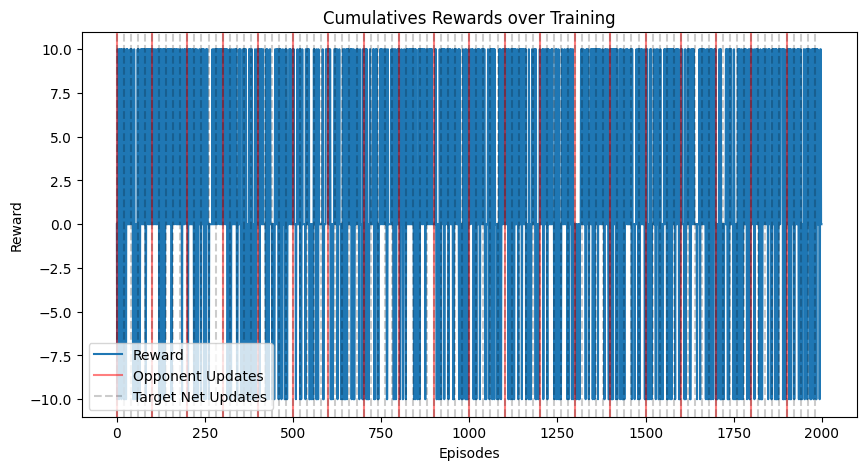

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(list_reward, label="Reward")
for i in range(0, len(list_reward), opponent_update_freq):
    if i == 0:
        plt.axvline(x=i, color='red', linestyle='-', alpha=0.5, label="Opponent Updates")
    else:
        plt.axvline(x=i, color='red', linestyle='-', alpha=0.5)

for i in range(0, len(list_reward), target_update_freq):
    if i == 0:
        plt.axvline(x=i, color='black', linestyle='--', alpha=0.2, label="Target Net Updates")
    else:
        plt.axvline(x=i, color='black', linestyle='--', alpha=0.2)
    
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Cumulatives Rewards over Training")
plt.legend()
plt.show()

### Evaluate

In [ ]:
env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=False, final_reward_score_difference=False)
env.reset()

n_actions = env.action_space(controlled_agent).n
obs_shape = env.observe(controlled_agent)["observation"].shape  # (10, 10, 5)
list_reward_training, policy_net_checkpoints, num_checkpoints = [], [], 0

checkpoint = torch.load("model_weights_DQN/test3.pth", weights_only=False)

policy_net = DuelingDQN(obs_shape, n_actions).to(device)
policy_net.load_state_dict(checkpoint['model_state_dict'])
opponent_net = DuelingDQN(obs_shape, n_actions).to(device)
opponent = 2

list_reward_training = checkpoint['list_reward']
policy_net_checkpoints = checkpoint['policy_net_checkpoints']
num_checkpoints = checkpoint['num_checkpoints']
print(f'Num checkpoints: {num_checkpoints}')

list_reward = []
win_count = 0
print(f"Opponent {opponent} / {num_checkpoints}")
opponent_net.load_state_dict(policy_net_checkpoints[opponent])

env.reset()
total_reward = 0

while env.agents:
    current_agent = env.agent_selection
    observation = env.observe(current_agent)
    legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
    
        
    if current_agent == controlled_agent:
        state = observation["observation"]
        action_mask = observation["action_mask"]
        action, _ = select_action_dqn(policy_net, state, action_mask, device, verbose=True)
        env.step(action)
        
        reward = env.rewards[current_agent]
        total_reward += reward
        list_reward.append(total_reward)
    else: 
        state = observation["observation"]
        action_mask = observation["action_mask"]
        action, _ = select_action_dqn(opponent_net, state, action_mask, device)
        
        # print(f'action : {action}')
        env.step(action)
    
    
    print(f"Current agent: {current_agent} Action: {action}")
    print("== REWARD ==")
    print(f'rewards : {env.rewards}')
    print(f'cumulative reward : {env._cumulative_rewards}')
    print("== RENDER ==")
    env.render()
    print('\n')
print(f"Opponent: {opponent} / Winnner: {env.winner}")


Num checkpoints: 4
Opponent 2 / 4


TypeError: select_action_dqn() missing 2 required positional arguments: 'device' and 'method'

In [ ]:
def evaluate_DQN(name, opponents, num_episodes_eval=100, epsilon=0.15):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=True, final_reward_score_difference=False)
    env.reset()

    n_actions = env.action_space(controlled_agent).n
    obs_shape = env.observe(controlled_agent)["observation"].shape  # (10, 10, 5)
    list_reward_training, policy_net_checkpoints, num_checkpoints = [], [], 0
    
    checkpoint = torch.load(f"model_weights_DQN/{name}.pth", weights_only=False)

    policy_net = DuelingDQN(obs_shape, n_actions).to(device)
    policy_net.load_state_dict(checkpoint['model_state_dict'])
    opponent_net = DuelingDQN(obs_shape, n_actions).to(device)
    opponents.append(-2)
    
    list_reward_training = checkpoint['list_reward']
    policy_net_checkpoints = checkpoint['policy_net_checkpoints']
    num_checkpoints = checkpoint['num_checkpoints']
    print(f'Num checkpoints: {num_checkpoints}')
    
    for opponent in opponents:
        list_reward = []
        win_count = 0
        print(f"Opponent {opponent} / {num_checkpoints}")
        if opponent != -2:
            opponent_net.load_state_dict(policy_net_checkpoints[opponent])
        else:
            opponent_net.load_state_dict(policy_net.state_dict())
            
        for episode in tqdm(range(num_episodes_eval)):
            env.reset()
            total_reward = 0

            while env.agents:
                current_agent = env.agent_selection
                observation = env.observe(current_agent)
                legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
                
                    
                if current_agent == controlled_agent:
                    state = observation["observation"]
                    action_mask = observation["action_mask"]
                    action, _ = select_action_dqn(policy_net, state, action_mask, device, verbose=True)
                    env.step(action)
                    
                    reward = env.rewards[current_agent]
                    total_reward += reward
                    list_reward.append(total_reward)
                else: 
                    if opponent == -1: # random opponent
                        action = random.choice(legal_moves)
                    else:
                        if random.random() < epsilon:
                            action = random.choice(legal_moves)
                        else:
                            state = observation["observation"]
                            action_mask = observation["action_mask"]
                            action, _ = select_action_dqn(opponent_net, state, action_mask, device)
                        
                        # print(f'action : {action}')
                    env.step(action)
                        
            
            if env.winner == 0: # controlled_agent ("player_0") gagne
                win_count += 1
            elif env.winner == -1: # match nul : on peut compter 0.5 victoire
                win_count += 0.5
        
        avg_reward = sum(list_reward)/len(list_reward)
        print(f"Opponent {opponent} : {num_episodes_eval} episodes => Avg Reward : {avg_reward:.4f} // Winrate : {win_count/num_episodes_eval:.4f}")
        

In [ ]:
avg_reward = evaluate_DQN('test3', [-1, 0, 1, 2, 3, -2])
#89%

Num checkpoints: 4
Opponent -1 / 4


100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


Opponent -1 : 100 episodes => Avg Reward : 0.8993288590604027 // Winrate : 0.935
Opponent 0 / 4


100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


Opponent 0 : 100 episodes => Avg Reward : 0.03163265306122449 // Winrate : 0.69
Opponent 1 / 4


100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


Opponent 1 : 100 episodes => Avg Reward : -0.20184426229508196 // Winrate : 0.705
Opponent 2 / 4


100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


Opponent 2 : 100 episodes => Avg Reward : -0.17426545086119555 // Winrate : 0.66
Opponent 3 / 4


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


Opponent 3 : 100 episodes => Avg Reward : 0.07520325203252033 // Winrate : 0.74
Opponent -2 / 4


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


Opponent -2 : 100 episodes => Avg Reward : -0.07222787385554426 // Winrate : 0.735
Opponent -2 / 4


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]

Opponent -2 : 100 episodes => Avg Reward : 0.04294478527607362 // Winrate : 0.68
